In [8]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import os
import copy
import random

In [95]:
def parse_strcoords(strlist,img_height,return_int=True):
    x=[]
    y=[]
    
    for s in strlist:
        s=s.replace("(","")
        s=s.replace(")","")
        s=s.split(",")
        x.append(float(s[0]))
        y.append(img_height-float(s[1])) # y-coord in the Unity generator space is positive in the upward direction, needs to be flipped in the image space
    
    x=np.array(x)
    y=np.array(y)
    
    if return_int:
        x=x.astype(int)
        y=y.astype(int)
    
    xy=np.concatenate((x[:,None],y[:,None]),axis=1)
    
    return xy

def extract_gazevec(metadata):
    vec_str=metadata['eye_details']['look_vec']
    vec_str=vec_str.replace("(","")
    vec_str=vec_str.replace(")","").split(",")
    
    x=float(vec_str[0])
    y=-1*float(vec_str[1])
    
    return np.array([x,y])

def draw_landmarks(img,xycoords,color='cyan',radius=2,width=1):
    
    underlay=copy.deepcopy(img)
    
    draw = ImageDraw.Draw(underlay)
    xy1=xycoords-radius
    xy2=xycoords+radius
    
    for (x1,y1),(x2,y2) in zip(xy1,xy2):
        draw.ellipse([x1,y1,x2,y2],fill=color,outline=None,width=width)
    
    return underlay
    

def draw_gaze_vector(img,iris_landmarks,gaze_vec,length=3,color='cyan',width=1):
    [dx,dy]=(gaze_vec*length).astype(int)
    
    [cenx,ceny]=np.mean(iris_landmarks,0).astype(int)
    dest_x=int(cenx+dx)
    dest_y=int(ceny+dy)
    
    underlay=copy.deepcopy(img)
    draw=ImageDraw.Draw(underlay)
    
    draw.line([cenx,ceny,dest_x,dest_y],fill=color,width=width)
    
    return underlay
    
    

In [96]:
workdir="/home/jay/postgrad-portfolio/gaze-correction/data/unity-eyes/raw"

imgpaths=[os.path.join(workdir,i) for i in os.listdir(workdir) if ".jpg" in i]
jsonpaths=[os.path.join(workdir,i) for i in os.listdir(workdir) if ".json" in i]

imgpaths.sort()
jsonpaths.sort()

for ip,jp in zip(imgpaths,jsonpaths):
    assert ip.split(".")[0] == jp.split(".")[0]

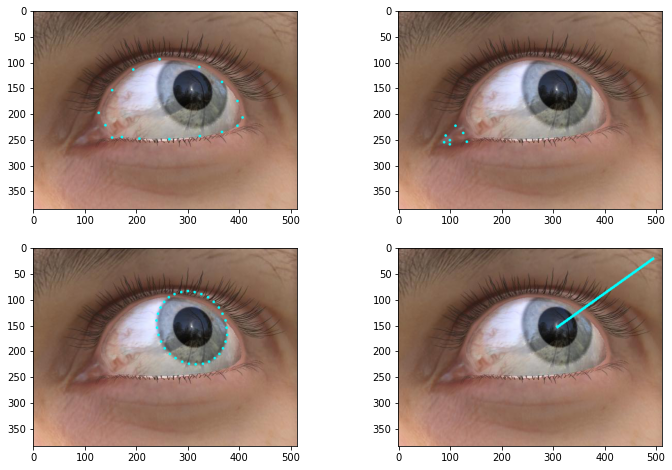

In [124]:
idx=random.choice(range(len(imgpaths)))
# idx=9970

img=Image.open(imgpaths[idx])
with open(jsonpaths[idx],"r") as jf:
    metadata=json.load(jf)
    
h=img.height
interior_landmarks=parse_strcoords(metadata['interior_margin_2d'],h)
caruncle_landmarks=parse_strcoords(metadata['caruncle_2d'],h)
iris_landmarks=parse_strcoords(metadata['iris_2d'],h)
gaze_vec=extract_gazevec(metadata)

interior_annotated=np.asarray(draw_landmarks(img,interior_landmarks))
caruncle_annotated=np.asarray(draw_landmarks(img,caruncle_landmarks))
iris_annotated=np.asarray(draw_landmarks(img,iris_landmarks))
gaze_annotated=np.asarray(draw_gaze_vector(img,iris_landmarks,gaze_vec,length=500,width=5))

plt.figure(figsize=(12,8))
plt.subplot(221).imshow(interior_annotated)
plt.subplot(222).imshow(caruncle_annotated)
plt.subplot(223).imshow(iris_annotated)
plt.subplot(224).imshow(gaze_annotated)